# **KLASIFIKASI JENIS BUNGA DENGAN CNN**

# **Download Data Set**

In [19]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Flower_Color.zip

--2023-12-25 22:53:51--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Flower_Color.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.159, 52.219.160.95, 52.219.158.115, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52779776 (50M) [application/x-zip-compressed]
Saving to: 'Flower_Color.zip.2'

Flower_Color.zip.2  100%[===================>]  50.33M  11.5MB/s    in 4.8s    

2023-12-25 22:53:57 (10.5 MB/s) - 'Flower_Color.zip.2' saved [52779776/52779776]



# **Unzip Data Set**

In [20]:
!unzip -qo Flower_Color.zip

# **Import Library**

In [25]:
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU
import seaborn as sns

# **Pre-Processing**

**Load Gambar dan Konversi ke Array**

In [26]:
# Fungsi untuk memuat gambar dari jalur file yang diberikan dan mengonversinya menjadi array numpy
def image_to_tensor(img_path):
    # Memuat gambar menggunakan fungsi load_img dari modul keras_image
    img = keras_image.load_img("Flower Color/flower_images/" + img_path, target_size=(128, 128))
    
    # Mengonversi gambar menjadi array numpy menggunakan fungsi img_to_array
    x = keras_image.img_to_array(img)
    
    # Menambahkan dimensi tambahan pada array untuk sesuai dengan input model
    return np.expand_dims(x, axis=0)

**Konversi Gambar ke Tensor**

In [27]:
# Fungsi untuk mengonversi beberapa gambar menjadi tensor
def data_to_tensor(img_paths):
    # Membuat daftar tensor dengan menggunakan fungsi image_to_tensor pada setiap jalur gambar
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    
    # Menggabungkan tensor-tensor tersebut menjadi satu array menggunakan np.vstack
    return np.vstack(list_of_tensors)

**Memuat Data**

In [28]:
# Mengatasi potensi kesalahan pada pembacaan gambar dengan mengizinkan pengguntingan gambar yang terpotong
ImageFile.LOAD_TRUNCATED_IMAGES = True 

# Memuat data label dari file CSV yang berisi informasi tentang gambar bunga
data = pd.read_csv("Flower Color/flower_images/flower_labels.csv")

# Mengambil kolom 'file' sebagai jalur file gambar dan 'label' sebagai target label
files = data['file']
targets = data['label'].values

# Mengonversi jalur file gambar menjadi tensor-tensor menggunakan fungsi data_to_tensor
tensors = data_to_tensor(files)

100%|██████████| 210/210 [00:00<00:00, 434.85it/s]


In [29]:
# Menampilkan lima baris pertama dari DataFrame 'data' untuk melihat cuplikan awal dari data
data.head()

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0


In [30]:
# Menampilkan bentuk (shape) 
tensors.shape

(210, 128, 128, 3)

In [31]:
# Menampilkan bentuk (shape) dari  target 'targets'
targets.shape

(210,)

In [32]:
# Membuat daftar (list) yang berisi nama-nama kategori bunga
names = ['phlox', 'rose', 'calendula', 'iris', 'max chrysanthemum', 
         'bellflower', 'viola', 'rudbeckia laciniata', 'peony', 'aquilegia']

# **Menampilkan Contoh Image**

In [33]:
# Fungsi untuk menampilkan sampel gambar
def display_images(img_path, ax):
    # Membaca gambar menggunakan OpenCV dari jalur file yang diberikan
    img = cv2.imread("Flower Color/flower_images/" + img_path)
    
    # Mengubah warna gambar dari format BGR (OpenCV) menjadi RGB
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

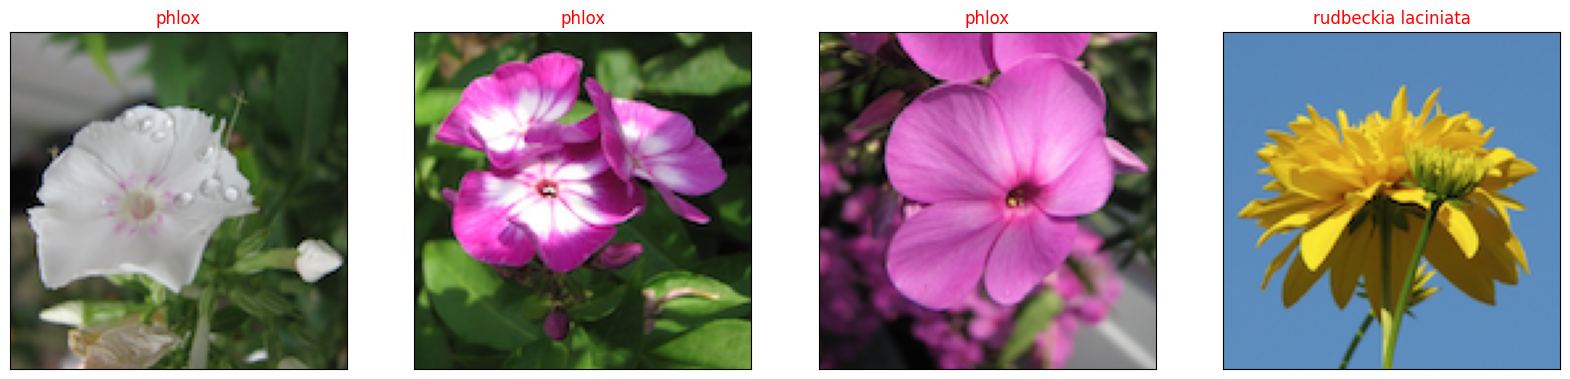

In [34]:
# Membuat objek gambar (figure) dengan ukuran 20x10 inci
fig = plt.figure(figsize=(20, 10))

# Melakukan iterasi sebanyak 4 kali untuk menampilkan empat gambar sampel
for i in range(4):
    # Menambahkan subplot ke dalam gambar dengan konfigurasi 2 baris x 4 kolom
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    
    # Menetapkan judul subplot dengan menggunakan nama kategori dari daftar 'names' 
    # berdasarkan target pada indeks tertentu, dengan warna teks merah
    ax.set_title(names[targets[i+10]], color='red')
    
    # Memanggil fungsi display_images untuk menampilkan gambar pada subplot
    display_images(files[i+10], ax)

# **Menyimpan data dalam .h5 untuk kedepannya**

In [35]:
# Menyimpan data dalam file h5 untuk penggunaan kedepan
# Membuat file h5 dan menyimpan data
with h5py.File('FlowerColorImages.h5', 'w') as f:
    # Membuat dataset 'images' dalam file h5 dan menyimpan data tensor
    f.create_dataset('images', data=tensors)
    
    # Membuat dataset 'labels' dalam file h5 dan menyimpan data target
    f.create_dataset('labels', data=targets)
    
    # Menutup file h5 setelah selesai menyimpan data
    f.close()

In [36]:
# Membaca file h5
f = h5py.File('FlowerColorImages.h5', 'r')

# Mendapatkan daftar semua grup dalam file h5
keys = list(f.keys())
keys

['images', 'labels']

# **Membuat Tensor dan Target**

In [37]:
# Membuat tensor dan target dari data dalam file h5
tensors = np.array(f[keys[0]])
targets = np.array(f[keys[1]])

# Menampilkan bentuk (shape) dari tensor dan target
print('Tensor shape:', tensors.shape)
print('Target shape', targets.shape)

Tensor shape: (210, 128, 128, 3)
Target shape (210,)


In [38]:
# Membuat file CSV dan menyimpan data
# Mengubah bentuk tensor menjadi dimensi yang sesuai untuk penyimpanan dalam file CSV
images_csv = tensors.reshape(210, 128 * 128 * 3)

# Menyimpan data dalam file CSV dengan format integer dan delimiter koma
np.savetxt("flower_images.csv", images_csv, fmt='%i', delimiter=",")

In [39]:
# Membaca DataFrame pandas dari file CSV
data_images = pd.read_csv("flower_images.csv", header=None)

# Menampilkan lima baris pertama dari DataFrame
data_images.head()

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,13,22,10,14,23,9,16,24,10,16,...,44,59,38,38,26,25,16,117,74,78
1,38,49,30,37,50,30,38,52,30,40,...,9,9,10,8,7,7,7,5,5,5
2,65,83,48,72,87,58,74,90,62,81,...,35,52,70,38,56,74,41,58,76,42
3,162,53,102,147,66,91,156,80,97,169,...,69,105,44,67,103,43,68,103,43,68
4,193,52,78,194,51,76,195,58,85,197,...,199,253,179,200,248,163,189,229,120,154


In [40]:
# Menampilkan sepuluh baris pertama dan sepuluh kolom pertama dari DataFrame 'data_images'
data_images.iloc[:10, :10]# Menampilkan bentuk (shape) dari DataFrame 'data_images'

,0,1,2,3,4,5,6,7,8,9
0,13,22,10,14,23,9,16,24,10,16
1,38,49,30,37,50,30,38,52,30,40
2,65,83,48,72,87,58,74,90,62,81
3,162,53,102,147,66,91,156,80,97,169
4,193,52,78,194,51,76,195,58,85,197
5,53,76,55,53,76,55,53,77,56,53
6,8,9,8,8,9,9,9,9,9,8
7,9,9,8,9,9,9,8,8,8,8
8,195,127,169,188,118,160,135,76,101,55
9,7,7,7,8,7,7,8,9,8,9


In [41]:
data_images.shape

(210, 49152)

In [42]:
# Membaca tensor gambar dari DataFrame
tensors = data_images.values

# Menampilkan bentuk (shape) dari tensor gambar
tensors.shape

(210, 49152)

In [43]:
# Mengubah bentuk (shape) tensor menjadi format yang sesuai
tensors = tensors.reshape(-1, 128, 128, 3)

# Menampilkan bentuk (shape) baru dari tensor
tensors.shape

(210, 128, 128, 3)

# **Normalisasi Tensor**

In [44]:
# Normalisasi tensor
# Mengubah tipe data tensor menjadi float32 dan membagi setiap nilai dengan 255 untuk normalisasi
tensors = tensors.astype('float32') / 255


# **Melakukan one-hot encoding pada target**

In [45]:
# Melakukan one-hot encoding pada target
targets = to_categorical(targets, 10)

# **Memisahkan data**

In [46]:
# Memisahkan data
# Membagi data menjadi data pelatihan (training) dan data pengujian (testing)
x_train, x_test, y_train, y_test = train_test_split(tensors, targets, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Memisahkan data pengujian menjadi data pengujian (testing) dan data validasi (validation)
n = int(len(x_test) / 2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]


In [47]:
# Menampilkan bentuk (shape) dari data pelatihan (training)
x_train.shape, y_train.shape

((168, 128, 128, 3), (168, 10))

In [48]:
# Menampilkan bentuk (shape) dari data pengujian (testing)
x_test.shape, y_test.shape

((21, 128, 128, 3), (21, 10))

In [49]:
# Menampilkan bentuk (shape) dari data validasi
x_valid.shape, y_valid.shape

((21, 128, 128, 3), (21, 10))

Label:  rose


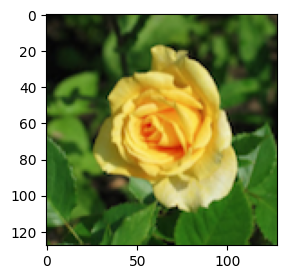

In [50]:
# Membaca dan menampilkan suatu tensor
# Menampilkan label dengan menggunakan nama kategori yang sesuai dengan indeks argmax dari target pelatihan (training)
print('Label: ', names[np.argmax(y_train[7])])

# Membuat dan menampilkan gambar dengan ukuran 3x3 inci dari tensor pelatihan (training) pada indeks tertentu
plt.figure(figsize=(3,3))
plt.imshow((x_train[7]))

# **Define Model and Train**

**Define Model**

In [51]:

# Mendefinisikan Model
def model():
    # Membuat objek model sequential
    model = Sequential()

    # Menambahkan layer konvolusi dengan 128 filter, ukuran kernel (3, 3), dan input shape sesuai dengan data pelatihan
    model.add(Conv2D(128, (3, 3), input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))  # Menambahkan fungsi aktivasi LeakyReLU
    
    # Menambahkan layer max pooling, mengurangi dimensi gambar dan menerapkan dropout
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Menambahkan layer konvolusi kedua dengan 128 filter dan ukuran kernel (3, 3)
    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))  # Menambahkan fungsi aktivasi LeakyReLU
    
    # Menambahkan layer max pooling, mengurangi dimensi gambar dan menerapkan dropout
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Menambahkan layer global max pooling untuk mereduksi dimensi sebelum masuk ke lapisan terhubung penuh
    model.add(GlobalMaxPooling2D())
    
    # Menambahkan layer terhubung penuh (fully connected) dengan 512 neuron dan fungsi aktivasi LeakyReLU
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5))  # Menerapkan dropout untuk mengurangi overfitting

    # Menambahkan layer terhubung penuh (fully connected) dengan 10 neuron (sesuai dengan jumlah kategori) dan fungsi aktivasi softmax
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # TODO: Mengompilasi model dengan fungsi loss categorical_crossentropy, optimizer adam, dan metrik akurasi
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Memanggil fungsi model() untuk membuat objek model
model = model()

**Membuat Callback**

In [52]:
# Membuat Callbacks

# Callback untuk menyimpan model terbaik selama pelatihan
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)

# Callback untuk mengurangi tingkat pembelajaran secara dinamis jika tidak ada perbaikan dalam validasi
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [53]:
# Menampilkan ringkasan (summary) dari model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 61, 61, 128)       0         
                                                        

**Melatih Model**

In [54]:
# Melatih model dan menyimpan riwayat pelatihan
history = model.fit(x_train, y_train, 
                    epochs=75, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, lr_reduction])

Epoch 1/75

Epoch 1: val_loss improved from inf to 2.30096, saving model to weights.best.model.hdf5
6/6 - 12s - loss: 2.3922 - accuracy: 0.0655 - val_loss: 2.3010 - val_accuracy: 0.1429 - lr: 0.0010 - 12s/epoch - 2s/step
Epoch 2/75


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2.30096 to 2.28711, saving model to weights.best.model.hdf5
6/6 - 10s - loss: 2.2855 - accuracy: 0.1310 - val_loss: 2.2871 - val_accuracy: 0.0952 - lr: 0.0010 - 10s/epoch - 2s/step
Epoch 3/75

Epoch 3: val_loss improved from 2.28711 to 2.23165, saving model to weights.best.model.hdf5
6/6 - 11s - loss: 2.2468 - accuracy: 0.1310 - val_loss: 2.2316 - val_accuracy: 0.1905 - lr: 0.0010 - 11s/epoch - 2s/step
Epoch 4/75

Epoch 4: val_loss improved from 2.23165 to 2.17231, saving model to weights.best.model.hdf5
6/6 - 10s - loss: 2.1437 - accuracy: 0.2857 - val_loss: 2.1723 - val_accuracy: 0.2857 - lr: 0.0010 - 10s/epoch - 2s/step
Epoch 5/75

Epoch 5: val_loss improved from 2.17231 to 2.04680, saving model to weights.best.model.hdf5
6/6 - 10s - loss: 2.0088 - accuracy: 0.3393 - val_loss: 2.0468 - val_accuracy: 0.2857 - lr: 0.0010 - 10s/epoch - 2s/step
Epoch 6/75

Epoch 6: val_loss improved from 2.04680 to 1.94500, saving model to weights.best.model.hdf5
6/6 - 1

**Melatih model dengan augmentasi gambar menggunakan ImageDataGenerator**

In [55]:
# Melatih model dengan augmentasi gambar menggunakan ImageDataGenerator
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)

# Melatih model menggunakan generator dan menyimpan riwayat pelatihan
dg_history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                 steps_per_epoch=len(x_train)//64, epochs=7, verbose=2, 
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[checkpointer, lr_reduction])


/tmp/ipykernel_42/1392766180.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  dg_history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),


Epoch 1/7

Epoch 1: val_loss did not improve from 0.48069
2/2 - 8s - loss: 0.4153 - accuracy: 0.8558 - val_loss: 0.4962 - val_accuracy: 0.9048 - lr: 4.0000e-05 - 8s/epoch - 4s/step
Epoch 2/7

Epoch 2: val_loss did not improve from 0.48069
2/2 - 8s - loss: 0.3913 - accuracy: 0.8438 - val_loss: 0.4988 - val_accuracy: 0.9048 - lr: 4.0000e-05 - 8s/epoch - 4s/step
Epoch 3/7

Epoch 3: val_loss did not improve from 0.48069
2/2 - 7s - loss: 0.2895 - accuracy: 0.9231 - val_loss: 0.5024 - val_accuracy: 0.8571 - lr: 4.0000e-05 - 7s/epoch - 4s/step
Epoch 4/7

Epoch 4: val_loss did not improve from 0.48069
2/2 - 7s - loss: 0.2973 - accuracy: 0.9327 - val_loss: 0.5063 - val_accuracy: 0.8571 - lr: 4.0000e-05 - 7s/epoch - 3s/step
Epoch 5/7

Epoch 5: val_loss did not improve from 0.48069
2/2 - 7s - loss: 0.2738 - accuracy: 0.9231 - val_loss: 0.5103 - val_accuracy: 0.8571 - lr: 4.0000e-05 - 7s/epoch - 3s/step
Epoch 6/7

Epoch 6: val_loss did not improve from 0.48069

Epoch 6: ReduceLROnPlateau reducing 

In [56]:
# Memuat bobot model dengan akurasi validasi terbaik
model.load_weights('weights.best.model.hdf5')

# **Evaluasi Model**

In [57]:
# Evaluasi Model
# Menghitung akurasi klasifikasi pada set pengujian (testing)
score = model.evaluate(x_test, y_test)

# Menampilkan skor evaluasi
score


1/1 [==============================] - 0s 373ms/step - loss: 0.7115 - accuracy: 0.7619


[0.7114885449409485, 0.761904776096344]

In [58]:
# Evaluasi Model pada Data Pelatihan
# Menghitung akurasi klasifikasi pada set pelatihan (training)
score = model.evaluate(x_train, y_train)

# Menampilkan skor evaluasi
score

6/6 [==============================] - 3s 454ms/step - loss: 0.2509 - accuracy: 0.9643


[0.2508527636528015, 0.9642857313156128]

In [59]:
# Evaluasi Model pada Data Validasi
# Menghitung akurasi klasifikasi pada set validasi
score = model.evaluate(x_valid, y_valid)

# Menampilkan skor evaluasi
score

1/1 [==============================] - 0s 373ms/step - loss: 0.4807 - accuracy: 0.9048


[0.48069167137145996, 0.9047619104385376]

# **Plot Akurasi Model**

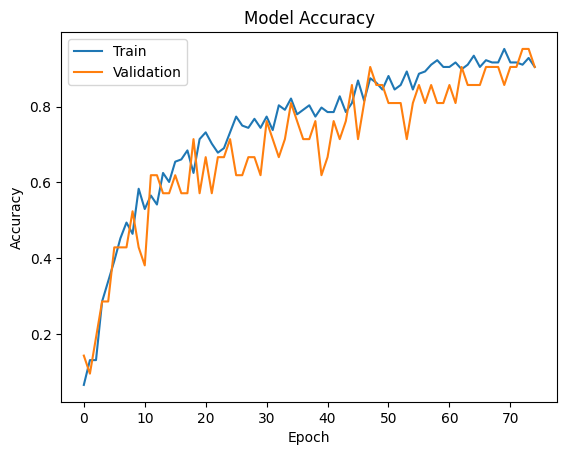

In [60]:
# Plot Akurasi Model
# Pada sumbu x, terdapat jumlah epoch, sedangkan pada sumbu y, terdapat nilai akurasi. Garis biru mewakili akurasi pada data pelatihan, dan garis oranye mewakili akurasi pada data validasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Plot Loss Model**

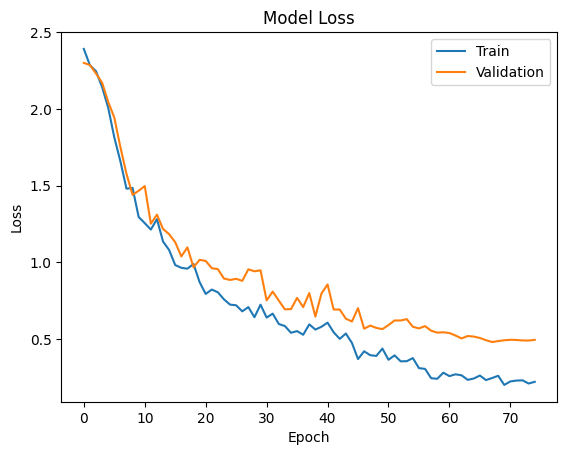

In [61]:
# Plot Loss Model
# Pada sumbu x, terdapat jumlah epoch, sedangkan pada sumbu y, terdapat nilai loss. Garis biru mewakili loss pada data pelatihan, dan garis oranye mewakili loss pada data validasi.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [62]:
# Menyimpan model ke dalam file h5
model.save('model.h5')

In [63]:
# Memuat model dari file h5
model1 = load_model('model.h5')

# **Prediksi**

In [64]:
# Prediksi Model untuk dataset pengujian (testing)
# membuat prediksi menggunakan model (model1) pada dataset pengujian (x_test). Hasil prediksi disimpan dalam variabel y_test_predict.
y_test_predict = model1.predict(x_test)


1/1 [==============================] - 0s 453ms/step


In [65]:
# Mengambil indeks dengan nilai tertinggi dari setiap prediksi
y_test_predict = np.argmax(y_test_predict, axis=1)

# **Menampilkan Prediksi**

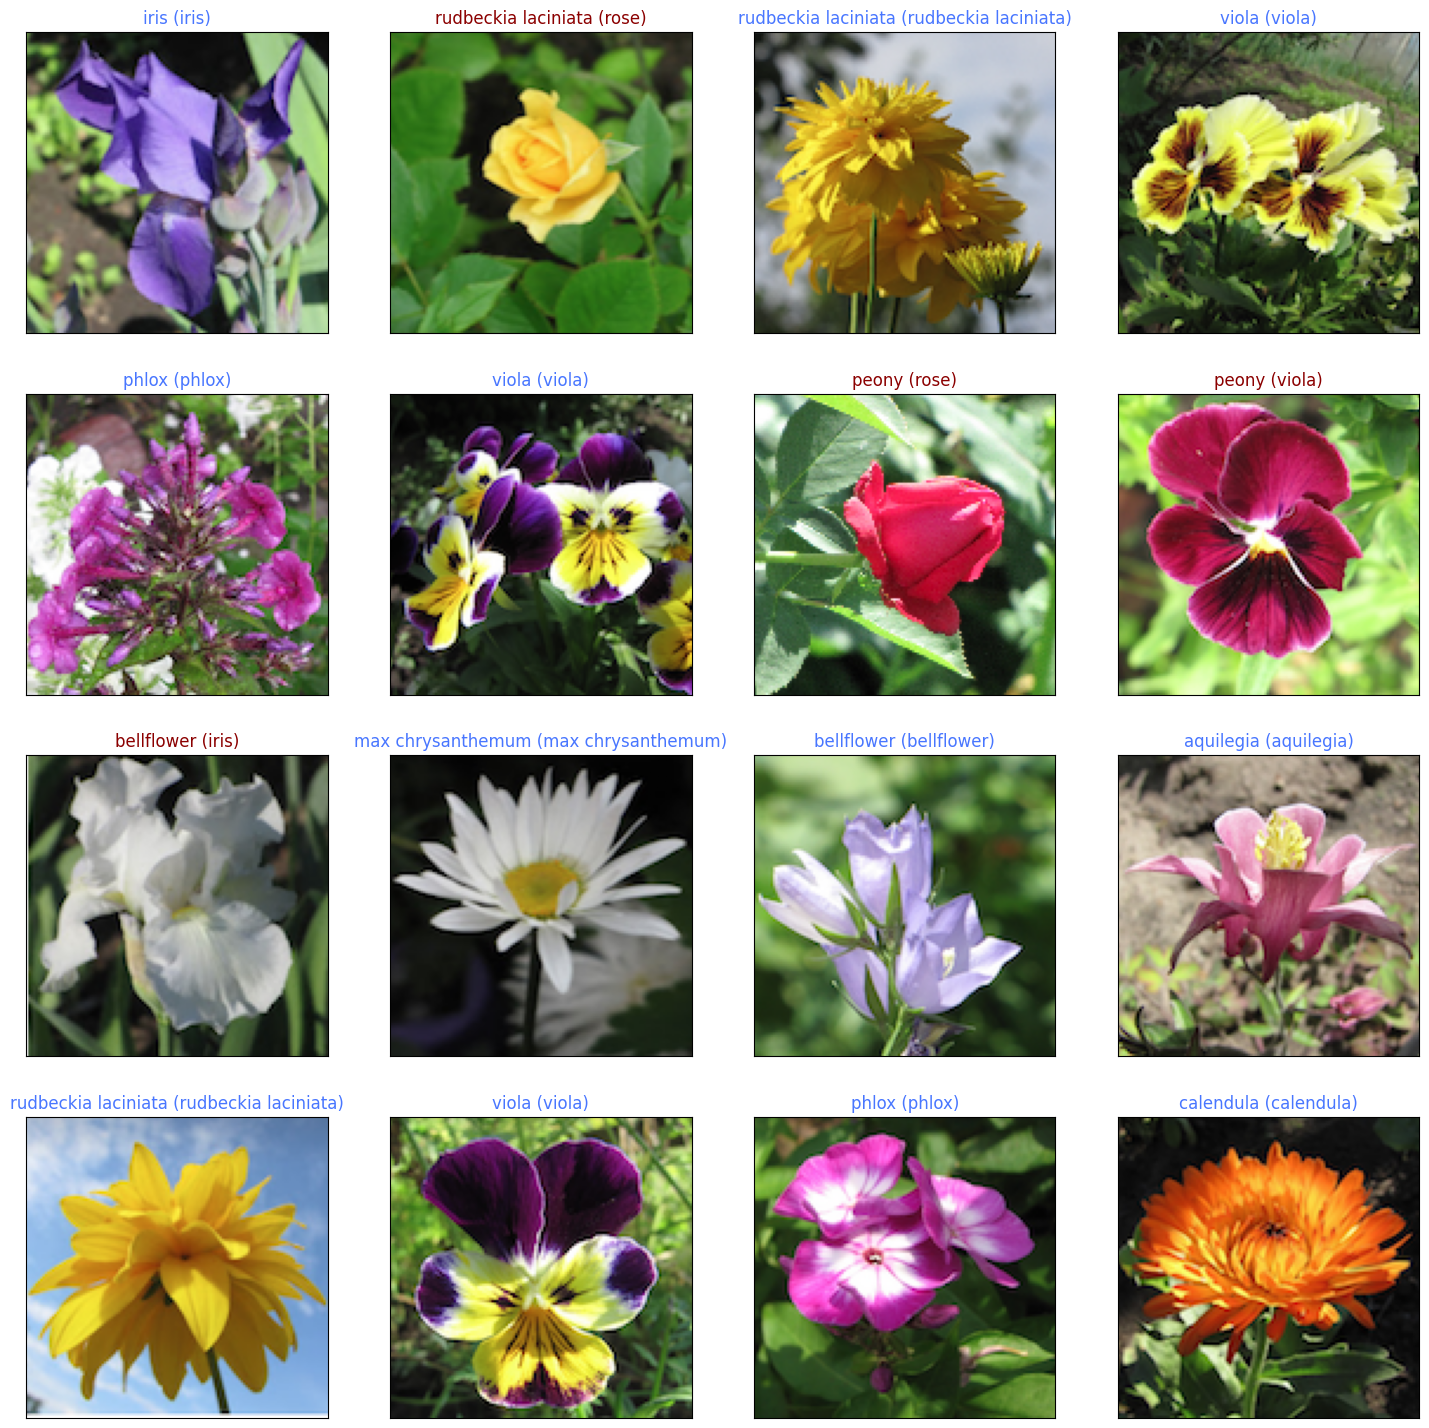

In [66]:
# Menampilkan label sebenarnya dan prediksi  
# digunakan untuk menampilkan gambar dari dataset pengujian beserta label sebenarnya dan prediksi model. Untuk setiap gambar, label prediksi ditampilkan dengan warna biru jika prediksi benar, dan warna merah tua jika prediksi salah. 
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))
